# **Experiment Notebook: Unsupervised Learning: Anomaly Detection**



**Katherin Gomez Londono - 24611687**

## Context


The bank has been systematically collecting transactional data from its customers for the past three years but has not fully exploited this wealth of information. This gap presents a unique opportunity for the data science team to introduce innovative solutions and set a precedent for data-driven decision-making within the bank.

The business case for this notebook is **Unsupervised Learning: Anomaly Detection**.

**Objective:** Detect abnormal spending behaviours among customers, allowing the Customer Support Team to proactively reach out to customers exhibiting unusual patterns to address potential issues such as financial distress or unauthorised transactions.

**Methodology:** Train a IsolationForest model on a dataset containing credit card transactions and customer data to detect abnormal behaviours such as unusually high or low transaction amounts, uncommon merchant locations, irregular transaction hours, atypical spending categories or any pattern deviations.

**Isolation Forest** is generally more scalable and requires less parameter tuning compared to LOF. It also performs well with high-dimensional data and might be more efficient for larger datasets like this one.

**Data:** Raw dataset can be downloaded here: https://drive.google.com/file/d/1ipwbg0VClq9OGYP-B9wnFegKxPneMFug/view?usp=drive_link

It contains a folder called "bank_transactions.zip", download it, unzip it and save it in your Google Drive.

###0. Import Packages & Set Global Variables

**[0.1]** Remove the deprecation warnings

In [ ]:
import warnings

# Suppress deprecation warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

**[0.2]** Install relevant packages

In [ ]:
# Install packages
! pip install -r https://raw.githubusercontent.com/aso-uts/labs_datasets/main/36106-mlaa/requirements.txt
! pip install dataprep
! pip install basemap

  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.6.0 requires sqlalchemy<3.0dev,>=1.4, but you have sqlalchemy 1.3.24 which is incompatible.
dataprep 0.4.5 requires pandas<2.0,>=1.1, but you have pandas 2.1.1 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.1.1 which is incompatible.
panel 1.3.8 requires bokeh<3.4.0,>=3.2.0, but you have bokeh 2.4.3 which is incompatible.
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2

**[0.3]** Import relevant packages

In [ ]:
# Import packages
from google.colab import drive
import os
import pandas as pd
from dataprep.eda import plot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.basemap import Basemap
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import altair as alt

**[0.4]** Set global variables

In [ ]:
# Constant random state
random_state = 42

In [ ]:
# Display max columns
pd.set_option('display.max_columns', None)

### 1.   Load Dataset

**[1.1]** Mount Google Drive

In [ ]:
# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


**[1.2]** Create a variable called `folder_path` containing the path of the "data" folder which contains the CSVs



In [ ]:
"""
To run this code, replace the folder_path with the path where you have saved the bank_transactions folder

"""
# Define folder path
folder_path = "/content/drive/MyDrive/Master - UTS/Autumn 2024/ML Algorithms and Applications/Group_34_AT3_240524/data/"

**[1.3]** Extract and read the transactions CSVs


In [ ]:
# Extracing list of transaction dataframes in folder, then read into full df
transaction_df_names = [df for df in os.listdir(folder_path) if "transactions" in df]
num_transaction_dfs = len(transaction_df_names)
transaction_df = pd.DataFrame()

for df_name in transaction_df_names:
  df = pd.read_csv(f"{folder_path}{df_name}", engine='python', sep="\|")
  transaction_df = pd.concat([transaction_df, df], ignore_index=True)

**[1.4]** Extract and read the customers CSV

In [ ]:
# Load customer data
customer_df_name = "customers.csv"
customer_df = pd.read_csv(f"{folder_path}{customer_df_name}", engine='python', sep="\|")

**[1.5]** Merge transaction and customer data into a `df_merged` dataframe through "cc_num" column

In [ ]:
# Merge into single dataframe through 'cc_num' column
df_merged = pd.merge(transaction_df, customer_df, on='cc_num', how='left')

# Delete and rename duplicate column
df_merged = df_merged.drop(columns=['acct_num_y'])
df_merged = df_merged.rename(columns={'acct_num_x': 'acct_num'})

Now, the datasets are merged into a single dataframe called `df_merged` and it is ready for exploration and preprocessing.

### 2. Explore Dataset

**[2.1]** Display the first 5 rows of `df_merged`

In [ ]:
df_merged.head()

cc_num      acct_num                         trans_num   unix_time  \
0  4218196001337  888022315787  91ab12e73ef38206e1121e9648d2408d  1558719550   
1  4218196001337  888022315787  071553d533a6822a4431c354c434ddcb  1569425519   
2  4218196001337  888022315787  0cfad38ef15e4749eff68dc83f62c151  1577205601   
3  4218196001337  888022315787  5782693d7c70f062f258cb30bfa8900f  1571428238   
4  4218196001337  888022315787  35fd7db657d7e30dd608c37f7798186e  1549840400   

        category    amt is_fraud        merchant  merch_lat  merch_long  \
0  gas_transport  69.12        0  Phillips Group  39.491416  -75.588522   
1    grocery_pos  68.11        0      Tucker Ltd  40.890319  -75.573359   
2       misc_net  40.35        0       Dixon PLC  39.244958  -74.475327   
3    grocery_pos  96.22        0  Lambert-Cooper  39.656925  -75.802342   
4  gas_transport  71.89        0    Griffith LLC  40.313342  -74.220434   

           ssn     first     last gender                street    city state  \
0  115-04-4507  Jonathan  Johnson      M  863 Lawrence Valleys  Ambler    PA   
1  115-04-4507  Jonathan  Johnson      M  863 Lawrence Valleys  Ambler    PA   
2  115-04-4507  Jonathan  Johnson      M  863 Lawrence Valleys  Ambler    PA   
3  115-04-4507  Jonathan  Johnson      M  863 Lawrence Valleys  Ambler    PA   
4  115-04-4507  Jonathan  Johnson      M  863 Lawrence Valleys  Ambler    PA   

     zip      lat     long  city_pop                    job         dob  
0  19002  40.1809 -75.2156     32412  Accounting technician  1959-10-03  
1  19002  40.1809 -75.2156     32412  Accounting technician  1959-10-03  
2  19002  40.1809 -75.2156     32412  Accounting technician  1959-10-03  
3  19002  40.1809 -75.2156     32412  Accounting technician  1959-10-03  
4  19002  40.1809 -75.2156     32412  Accounting technician  1959-10-03

**[2.2]** Display the dimensions of `df_merged`

In [ ]:
df_merged.shape

(4260904, 23)

The dataset contains 23 columns and 4,260,904 records.

**[2.3]** Display the summary of `df_merged`

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260904 entries, 0 to 4260903
Data columns (total 23 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      object 
 1   acct_num    object 
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
 10  ssn         object 
 11  first       object 
 12  last        object 
 13  gender      object 
 14  street      object 
 15  city        object 
 16  state       object 
 17  zip         int64  
 18  lat         float64
 19  long        float64
 20  city_pop    int64  
 21  job         object 
 22  dob         object 
dtypes: float64(5), int64(2), object(16)
memory usage: 780.2+ MB


The dataset contains:

*   **Identifiers:** 4. `cc_num`, `acct_num`, `trans_num`, `ssn`
*   **Categorical Variables:** 9. `category`, `merchant`, `first`, `last`, `gender`, `street`, `city`, `state`, `job`
*   **Numerical Variables:** 9. `unix_time`, `amt`, `is_fraud`, `merch_lat`, `merch_long`, `zip`, `lat`, `long`, `city_pop`
*   **Date:** 1. `dob`

They will be transformed to the correct data type according to this list in the next steps.



**[2.4]** Display the descriptive statistics of `df_merged`

In [ ]:
df_merged.describe(include='all')

cc_num      acct_num                         trans_num  \
count   4.260904e+06  4.260904e+06                           4260904   
unique  9.830000e+02  9.830000e+02                           4260904   
top     3.472085e+14  1.154613e+10  91ab12e73ef38206e1121e9648d2408d   
freq    1.091200e+04  1.091200e+04                                 1   
mean             NaN           NaN                               NaN   
std              NaN           NaN                               NaN   
min              NaN           NaN                               NaN   
25%              NaN           NaN                               NaN   
50%              NaN           NaN                               NaN   
75%              NaN           NaN                               NaN   
max              NaN           NaN                               NaN   

           unix_time      category           amt   is_fraud   merchant  \
count   4.260904e+06       4260904  4.260904e+06  4260904.0    4260904   
unique  4.114752e+06            14           NaN        2.0      21977   
top     1.671189e+09  shopping_pos           NaN        0.0  Smith PLC   
freq    5.000000e+00        420268           NaN  4255870.0       5737   
mean             NaN           NaN  6.898790e+01        NaN        NaN   
std              NaN           NaN  1.618467e+02        NaN        NaN   
min              NaN           NaN  1.000000e+00        NaN        NaN   
25%              NaN           NaN  9.100000e+00        NaN        NaN   
50%              NaN           NaN  4.449000e+01        NaN        NaN   
75%              NaN           NaN  8.158000e+01        NaN        NaN   
max              NaN           NaN  4.130053e+04        NaN        NaN   

           merch_lat    merch_long          ssn     first      last   gender  \
count   4.260904e+06  4.260904e+06      4260904   4260904   4260904  4260904   
unique           NaN           NaN          983       365       479        2   
top              NaN           NaN  205-73-5783  Jennifer  Williams        F   
freq             NaN           NaN        10912    108945    110907  2175896   
mean    3.735276e+01 -9.247610e+01          NaN       NaN       NaN      NaN   
std     5.504630e+00  1.741603e+01          NaN       NaN       NaN      NaN   
min     1.859001e+01 -1.603677e+02          NaN       NaN       NaN      NaN   
25%     3.370138e+01 -9.903072e+01          NaN       NaN       NaN      NaN   
50%     3.819365e+01 -8.727445e+01          NaN       NaN       NaN      NaN   
75%     4.120567e+01 -7.966098e+01          NaN       NaN       NaN      NaN   
max     6.577610e+01 -6.724632e+01          NaN       NaN       NaN      NaN   

                             street      city    state           zip  \
count                       4260904   4260904  4260904  4.260904e+06   
unique                          983       726       51           NaN   
top     2531 Diane Landing Apt. 510  Brooklyn       CA           NaN   
freq                          10912     74282   505426           NaN   
mean                            NaN       NaN      NaN  5.190384e+04   
std                             NaN       NaN      NaN  2.996720e+04   
min                             NaN       NaN      NaN  1.571000e+03   
25%                             NaN       NaN      NaN  2.750500e+04   
50%                             NaN       NaN      NaN  4.920200e+04   
75%                             NaN       NaN      NaN  7.870400e+04   
max                             NaN       NaN      NaN  9.970500e+04   

                 lat          long      city_pop                       job  \
count   4.260904e+06  4.260904e+06  4.260904e+06                   4260904   
unique           NaN           NaN           NaN                       505   
top              NaN           NaN           NaN  Computer games developer   
freq             NaN           NaN           NaN                     33859   
mean    3.735269e+01 -9.247593e+01  3.038011

*   There are 983 unique credit card numbers (`cc_num`), 983 unique account numbers (`acct_num`) and 983 `ssn`, indicating multiple transactions per card, per account and per customer.
*   The `is_fraud` column has two unique values (0 and 1), representing non-fraudulent and fraudulent transactions. There are 4,255,870 non-fraudulent transactions and 5,034 fraudulent transactions.
*   The `category` column has 14 unique categories, with the most frequent category being shopping_pos, occurring 420,268 times.
*   The average transaction amount (`amt`) is approximately 68.99, with a wide standard deviation of 161.85, indicating high variability in transaction amounts.
*   There are 21,977 unique merchants (`merchant`).
*   Gender distribution is evenly split between male (2,085,008) and female (2,175,896).
*   States are represented by 51 unique codes, and there are 726 unique cities.
*   The average city population (`city_pop`) is 303,801, with a standard deviation of 569,623, indicating a mix of small towns and large cities.
*   There are 505 unique job titles, with 'Computer games developer' being the most common.
*   Birth dates (`dob`) range widely, indicating a diverse age range among the customers.


**[2.5]** Checking missing values

In [ ]:
# Viewing NaN values of both original datasets to check data quality
dupes_transaction = transaction_df.isna().sum()
dupes_customer = customer_df.isna().sum()

print(f"Transaction dataset NA values:\n{dupes_transaction}")


print("\n")
print(f"Customer dataset NA values:\n{dupes_customer}")

Transaction dataset NA values:
cc_num        0
acct_num      0
trans_num     0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64


Customer dataset NA values:
ssn         0
cc_num      0
first       0
last        0
gender      0
street      0
city        0
state       0
zip         0
lat         0
long        0
city_pop    0
job         0
dob         0
acct_num    0
dtype: int64


There are no missing values in the dataset.

**[2.6]** Checking duplicates

In [ ]:
# Checking duplicates of original datasets to check data quality
dupes_transaction = transaction_df.duplicated().sum()
print(f'There are {dupes_transaction} duplicates within the transaction dataset.\n')

dupes_customer = customer_df.duplicated().sum()
print(f'There are {dupes_customer} duplicates within the customer dataset.\n')

There are 0 duplicates within the transaction dataset.

There are 0 duplicates within the customer dataset.



There are no duplicates in the dataset.

**[2.7]** Plots of `df_merged` using dataprep package


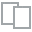
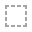
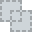
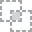
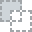
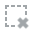
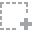
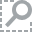
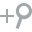
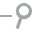
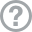
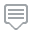
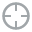
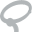
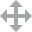
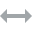
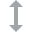
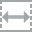
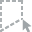
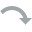
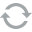
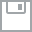
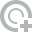
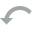
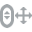
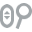
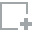
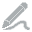
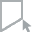
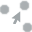
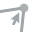
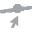

In [ ]:
# Plot distribution of df_merged
plot(df_merged)

### 3. Explore Target variable

Anomaly detection using unsupervised learning methods such as Isolation Forest does not require labelled data. The goal is to identify patterns that deviate significantly from the norm within the dataset. These algorithms find rare or significantly different data points without any prior knowledge of labels. They can identify new types of anomalies and can be applied to any dataset without pre-existing labels, making them versatile and easy to use. Therefore, **there is no target variable for this business use case**.

In the next section, the variables will be explored to gain more detailed insight into the dataset distribution.

### 4. Explore Variables of Interest

**[4.1]** Creation of `age_at_transaction` and `hour` columns

In [ ]:
# Cast dates to datetime in order to add new 'age_at_transaction' and 'hour' variables
df_merged['transaction_date'] = pd.to_datetime(df_merged['unix_time'], unit='s')
df_merged['dob'] = pd.to_datetime(df_merged['dob'])
df_merged['age_at_transaction'] = (df_merged['transaction_date'] - df_merged['dob']).dt.days // 365
df_merged['hour'] = df_merged['transaction_date'].dt.hour

**[4.2]** Set variables of interest for visualisation

In [ ]:
# Set variables of interest
cat_vars= df_merged[['category','merchant','gender','state','job']]
num_vars= df_merged[['amt', 'is_fraud', 'merch_lat','merch_long','zip','lat','long','city_pop', 'age_at_transaction', 'hour']]
date_vars= df_merged[['transaction_date','dob','age_at_transaction', 'hour']]

**[4.3]** Cast `is_fraud` as an integer

In [ ]:
# Cast 'is_fraud' column as an integer to plot correlation
df_merged['is_fraud'] = df_merged['is_fraud'].astype(int)

**[4.4]** Plots of categorical variables

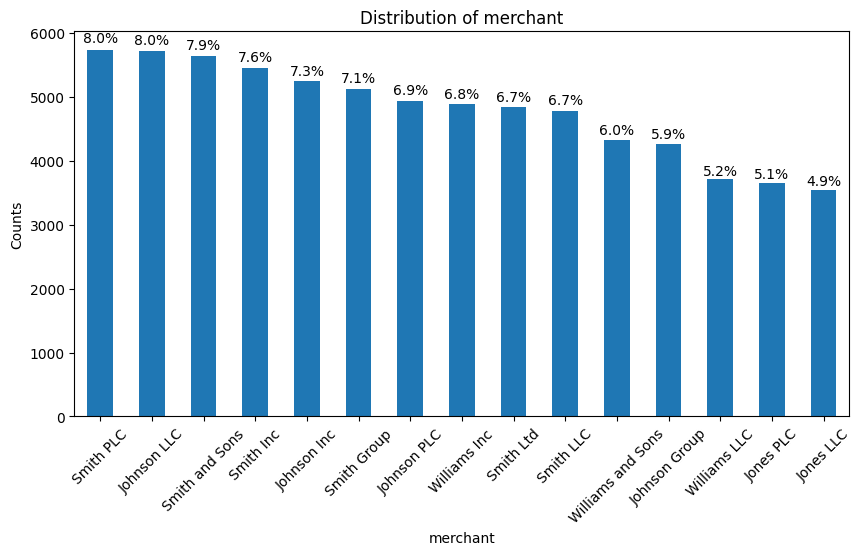

In [ ]:
# Plot distribution of categorical variables
for cat_var in cat_vars:
    counts = df_merged[cat_var].value_counts().head(15)
    total = counts.sum()

    plt.figure(figsize=(10, 5))
    ax = counts.plot(kind='bar')
    plt.title(f'Distribution of {cat_var}')
    plt.xlabel(cat_var)
    plt.ylabel('Counts')
    plt.xticks(rotation=45)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{(height/total)*100:.1f}%', (x + width/2, y + height*1.02), ha='center')

    plt.show()

*   **Distribution of Categories:** The graph shows the distribution of transaction counts across various categories, with 'shopping_pos', 'home' and 'grocery_pos' being the most frequent categories.
*   **Distribution of Merchants:** The graph presents the distribution of transactions among different merchants, with 'Smith PLC' and 'Johnson LLC' being the most frequent categories.
*   **Distribution of Gender:** Gender distribution is evenly split between male (48.9%) and female (51.1%).
*   **Distribution of States:** This distribution indicates where transactions are most commonly occurring: CA (California) and TX (Texas).
*   **Distribution of Jobs:** This graph categorises transaction counts by job type with 'Computer games developer' being the most common job.



**[4.5]** Plots of numerical variables

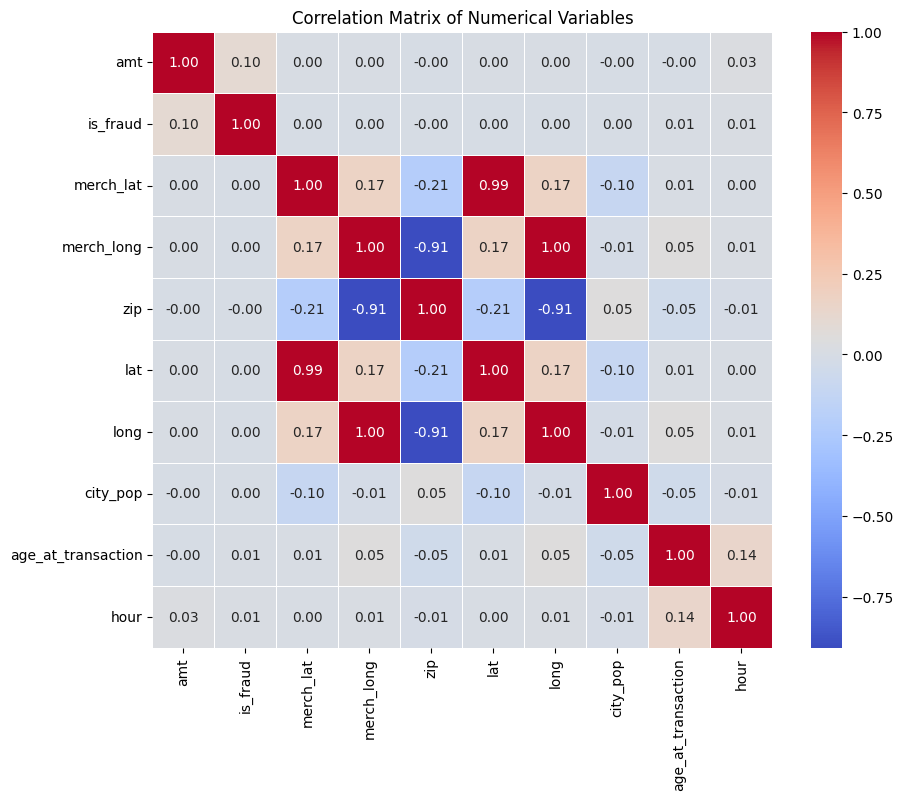

In [ ]:
# Plot correlation between numerical variables
corr_matrix = num_vars.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

The heatmap shows the correlation between various numerical variables.

*   **amt (Transaction Amount):** All correlations are very low, indicating that transaction amounts are relatively independent of other features. However, there is a weak positive correlation between transaction amount and fraud (0.10). Higher transaction amounts slightly increase the likelihood of fraud.
*   **is_fraud (Fraud Indicator):** All correlations are close to zero, suggesting that fraud is not strongly correlated with other numerical features.
*   **city_pop (City Population):** All correlations are very low, indicating that city population does not have strong relationships with other numerical variables in the dataset. It is because it's more reflective of demographic information than transaction-specific details.
*   **age_at_transaction:** There is a weak positive correlation with hour (0.14) suggesting that the age of the customer might slightly influence the time of transactions.
*   **hour (Time of Transaction):** The correlations are very low, indicating that transaction time does not strongly relate to other variables.



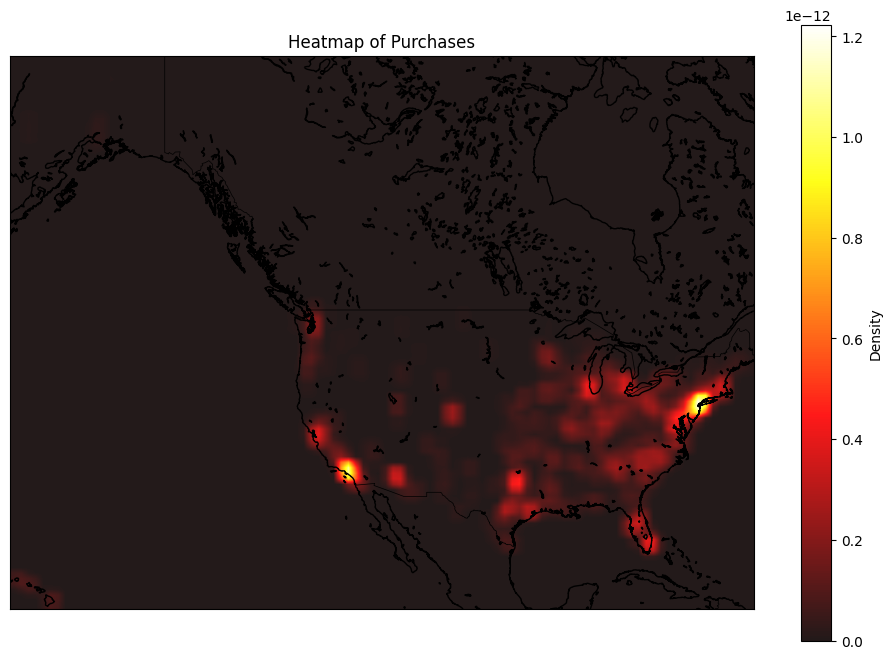

In [ ]:
# Plot heatmap of purchases
fig, ax = plt.subplots(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=df_merged['merch_lat'].min() , urcrnrlat=df_merged['merch_lat'].max() ,
            llcrnrlon=df_merged['merch_long'].min() , urcrnrlon=df_merged['merch_long'].max() , resolution='i', ax=ax)

m.drawcoastlines()
m.drawcountries()

x, y = m(df_merged['merch_long'].values, df_merged['merch_lat'].values)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=100, density=True)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.9, interpolation='bilinear')
plt.colorbar(label='Density')
plt.title('Heatmap of Purchases')
plt.show()

The heatmap visualises the density of purchases across the United States.

*   There is a significant concentration of purchases along the **East Coast**, particularly in the Northeast region, including areas like New York and Washington, D.C.
*   High-density areas are also evident on the **West Coast**, particularly in California around cities like Los Angeles and San Francisco.
*   There is notable density in the **Southern states**, including Texas and Florida.
*   **Urban vs. Rural:** Urban areas show higher purchase densities compared to rural areas. This aligns with expectations as urban areas typically have higher populations and more economic transactions.



**[4.6]** Plots of date variables

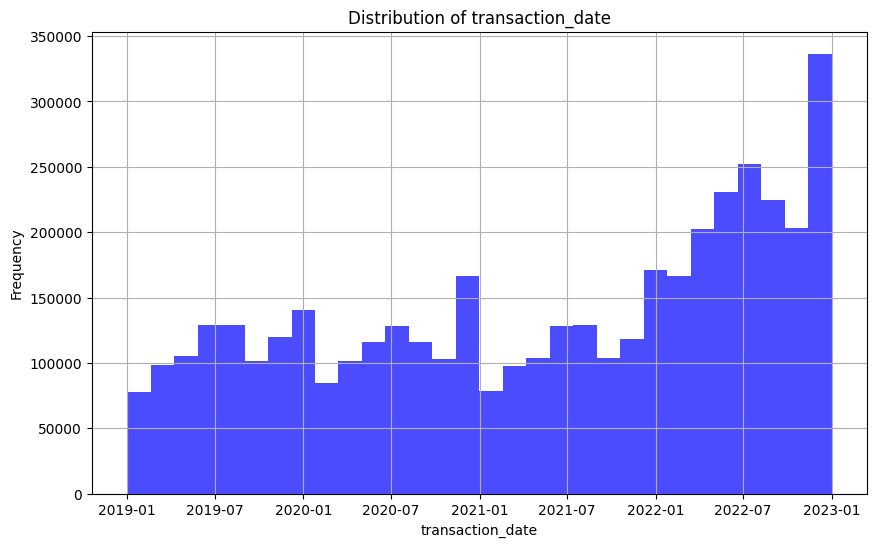

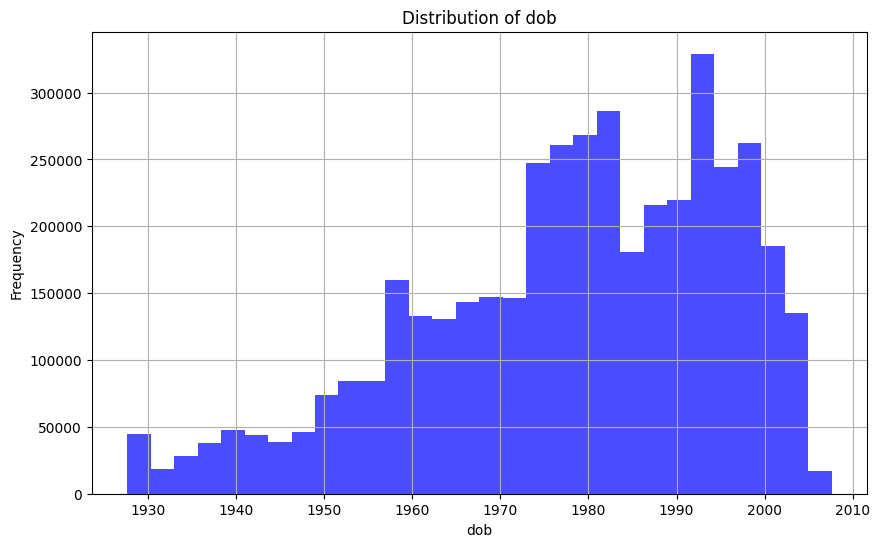

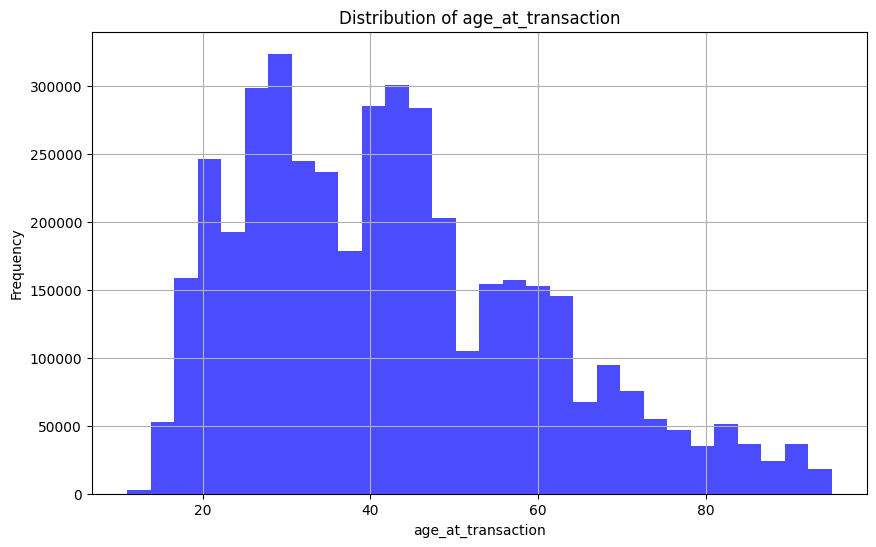

In [ ]:
# Plot distribution of date variables
for date_var in date_vars:
    plt.figure(figsize=(10, 6))
    plt.hist(df_merged[date_var].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {date_var}')
    plt.xlabel(date_var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

*   **Distribution of Transaction Dates:** There is a noticeable increasing trend in the number of transactions over the years. This is particularly evident from mid-2021 onwards, with a significant spike towards the end of 2022.
*   **Distribution of Date of Birth (dob):** The most significant peak occurs for customers born between 1980 and 1990. This suggests a large portion of the customer base falls within the 30-40 age range. There is a gradual decline in customers born after 2000, which is expected as this group includes younger individuals who might have fewer financial transactions or accounts.
*   **Distribution of Age at Transaction:** There is a significant peak for customers aged between 25 and 40 years, indicating a substantial number of transactions by this age group. There is a noticeable decline in the number of transactions for older customers.
*   **Distribution of Hour:** The highest transaction frequency is observed in the morning, particularly between 6 AM and 10 AM. There is a noticeable decrease in transaction frequency during the evening hours, which could be due to less economic activity during this period.



### 5. Prepare Data

**[5.1]** Select relevant features for anomaly detection

To determine which features to select for training the IsolationForest model to detect abnormal spending behaviors, we should focus on attributes that can help identify unusual patterns in transactions.

In [ ]:
# Select relevant features for anomaly detection
features = ['amt', 'merch_lat', 'merch_long', 'lat', 'long', 'hour', 'category', 'city_pop', 'age_at_transaction']

**Features to Select:**
*   **Transaction Amount (`amt`):** High or low transaction amounts can be indicative of anomalies.

*   **Merchant Location (Latitude and Longitude) (`merch_lat`, `merch_long`):** Uncommon merchant locations can help detect fraudulent activities or unusual spending behaviors.

*   **Customer Location (Latitude and Longitude) (`lat`, `long`):** Comparing the location of transactions with the usual locations of the customer can highlight anomalies (uncommon or distant locations).

*   **Time of Day (`hour`):** Unusual transaction times (e.g., very late at night) could be indicative of anomalies.

*   **Spending Category (`category`):** Changes in the type of merchants (e.g., a sudden spike in luxury goods spending) could be a red flag.

*   **Customer Demographics (`city_pop`, `age_at_transaction`):** They can provide additional context for the model.





**[5.2]** Separate features into a variable called `X`

In [ ]:
X = df_merged[features]

**[5.3]** Display the summary of `X`

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260904 entries, 0 to 4260903
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   amt                 float64
 1   merch_lat           float64
 2   merch_long          float64
 3   lat                 float64
 4   long                float64
 5   hour                int64  
 6   category            object 
 7   city_pop            int64  
 8   age_at_transaction  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 325.1+ MB


`category` needs to be encoded into numerical format using one-hot encoding. This allows the algorithm to understand and process the categorical data.

**[5.4]** One-hot encoding of `category`

Given that we are focusing on the Isolation Forest model for anomaly detection and the `category` column has 14 unique categories, one-hot encoding is a suitable and straightforward approach. It avoids introducing unintended ordinal relationships and works well with tree-based models like Isolation Forest.

In [ ]:
# One-Hot Encode the 'category' feature
encoder = OneHotEncoder()
category_encoded = encoder.fit_transform(X[['category']])
category_encoded_df = pd.DataFrame(category_encoded.toarray(), columns=encoder.get_feature_names_out(['category']))

# Concatenate the encoded category with the original features
X = pd.concat([X.drop('category', axis=1), category_encoded_df], axis=1)

**[5.5]** Standardise the features of `X`

While Isolation Forest can handle unnormalised data, it is generally a good practice to normalise the features, especially if they have significantly different scales. This can help ensure that all features are on a similar scale contributing equally to the anomaly detection process.

In [ ]:
# Standardise the dataset using Standard Scaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to keep column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first few rows of the standardised dataframe
X_scaled_df.head()

amt  merch_lat  merch_long       lat      long      hour  city_pop  \
0  0.000816   0.388520    0.969657  0.516629  0.991624  0.984076 -0.476436   
1 -0.005424   0.642652    0.970528  0.516629  0.991624  0.680265 -0.476436   
2 -0.176945   0.343748    1.033575  0.516629  0.991624  0.832171 -0.476436   
3  0.168259   0.418588    0.957380  0.516629  0.991624  1.287888 -0.476436   
4  0.017931   0.537836    1.048211  0.516629  0.991624  1.895510 -0.476436   

   age_at_transaction  category_entertainment  category_food_dining  \
0            0.911746               -0.281318             -0.285431   
1            0.968307               -0.281318             -0.285431   
2            0.968307               -0.281318             -0.285431   
3            0.968307               -0.281318             -0.285431   
4            0.911746               -0.281318             -0.285431   

   category_gas_transport  category_grocery_net  category_grocery_pos  \
0                3.265924                -0.211             -0.322318   
1               -0.306192                -0.211              3.102531   
2               -0.306192                -0.211             -0.322318   
3               -0.306192                -0.211              3.102531   
4                3.265924                -0.211             -0.322318   

   category_health_fitness  category_home  category_kids_pets  \
0                -0.258033      -0.323309           -0.309309   
1                -0.258033      -0.323309           -0.309309   
2                -0.258033      -0.323309           -0.309309   
3                -0.258033      -0.323309           -0.309309   
4                -0.258033      -0.323309           -0.309309   

   category_misc_net  category_misc_pos  category_personal_care  \
0          -0.216805           -0.26621                -0.27557   
1          -0.216805           -0.26621                -0.27557   
2           4.612437           -0.26621                -0.27557   
3          -0.216805           -0.26621                -0.27557   
4          -0.216805           -0.26621                -0.27557   

   category_shopping_net  category_shopping_pos  category_travel  
0              -0.278654              -0.330797         -0.18229  
1              -0.278654              -0.330797         -0.18229  
2              -0.278654              -0.330797         -0.18229  
3              -0.278654              -0.330797         -0.18229  
4              -0.278654              -0.330797         -0.18229

Now the dataset is ready for model training.

### 6. Split Dataset


For unsupervised learning tasks such as anomaly detection with IsolationForest, it is not necessary to split the data into training and test sets. Using the entire data set for training is common and can help the model learn underlying patterns and detect anomalies more effectively. As there is no explicit target variable, splitting the data may not provide any additional benefit for model training. Therefore, **the entire dataset will be used**.

### 7. Baseline Model

In the context of anomaly detection with Isolation Forest, establishing a baseline model for benchmarking can be challenging as typically there is no labelled data to compare against. Therefore, **a baseline model will not be built.**

### 8. Train Machine Learning Model: IsolationForest

**[8.1]** Instantiate the IsolationForest into a variable called `ifr` and fit it on `X_scaled_df`

In [ ]:
ifr = IsolationForest(random_state=random_state).fit(X_scaled_df)

**[8.2]** Save the predictions of `ifr` on `X_scaled_df` and save them into a variable called `preds`

In [ ]:
preds = ifr.predict(X_scaled_df)

**[8.3]** Display the number of observations of `preds` that have the value -1 (-1 indicates anomaly)

In [ ]:
(preds == -1).sum()

79728

The IsolationForest model has flagged 79,728 transactions as anomalies out of the entire dataset.

**[8.4]** Display the number of observations of `preds` that have the value 1 (1 indicates normal)

In [ ]:
(preds == 1).sum()

4181176

There are 4,181,176 normal transactions.

### 9. Analysing IsolationForest Results

**[9.1]** Add a new column to `df_merged` called `anomaly` that will contain the data from `preds`

In [ ]:
df_merged['anomaly'] = preds

**[9.2]** Create a Pandas mask called `anomaly_mask` that will check if observations from the column `anomaly` are equal to -1

In [ ]:
anomaly_mask = df_merged['anomaly'] == -1

In [ ]:
# Display the rows flagged as anomalies
anomalies_df = df_merged[anomaly_mask]
anomalies_df.head()

cc_num      acct_num                         trans_num  \
4136  4238849696532874  947268892251  52782c1958129aece96f6ecc7cab8aac   
4165  4238849696532874  947268892251  0cf7b560a6325bd1fcc1568069fca7d8   
4210  4238849696532874  947268892251  c505a0ac5efa6b0bc8815b9b48b54944   
7047  3573467065627293  370770979513  f9e2c5e8f9aec6364fc2b35eac036939   
7085  3573467065627293  370770979513  f74bcf1c6df61c8e1737a20f20d758bd   

       unix_time      category      amt  is_fraud  \
4136  1590371068  shopping_net  2076.66         0   
4165  1561132094   grocery_net  2783.13         0   
4210  1561495658   grocery_net  1048.74         0   
7047  1590869671  shopping_net   421.26         0   
7085  1620688268   food_dining   999.77         0   

                         merchant  merch_lat  merch_long          ssn  \
4136                    Ray-Baker  33.415898  -86.510936  406-83-7518   
4165                     Hahn Inc  33.268451  -87.209841  406-83-7518   
4210               Clay-Fernandez  32.467321  -87.596157  406-83-7518   
7047   Rivera, Taylor and Griffin  25.243530  -79.524060  552-96-8948   
7085  Moreno, Anderson and Jordan  26.327700  -80.295932  552-96-8948   

        first      last gender                  street        city state  \
4136  Brandon  Williams      M  26916 Carlson Mountain  Birmingham    AL   
4165  Brandon  Williams      M  26916 Carlson Mountain  Birmingham    AL   
4210  Brandon  Williams      M  26916 Carlson Mountain  Birmingham    AL   
7047   Joseph   Meadows      M       62720 Gray Forest   Hollywood    FL   
7085   Joseph   Meadows      M       62720 Gray Forest   Hollywood    FL   

        zip      lat     long  city_pop  \
4136  35242  33.3813 -86.7046    493806   
4165  35242  33.3813 -86.7046    493806   
4210  35242  33.3813 -86.7046    493806   
7047  33021  26.0218 -80.1891    420284   
7085  33021  26.0218 -80.1891    420284   

                                                job        dob  \
4136                            Seismic interpreter 1942-12-26   
4165                            Seismic interpreter 1942-12-26   
4210                            Seismic interpreter 1942-12-26   
7047  Programme researcher, broadcasting/film/video 1968-04-04   
7085  Programme researcher, broadcasting/film/video 1968-04-04   

        transaction_date  age_at_transaction  hour  anomaly  
4136 2020-05-25 01:44:28                  77     1       -1  
4165 2019-06-21 15:48:14                  76    15       -1  
4210 2019-06-25 20:47:38                  76    20       -1  
7047 2020-05-30 20:14:31                  52    20       -1  
7085 2021-05-10 23:11:08                  53    23       -1

**Descriptive Statistics of Anomalies vs. Normal Transactions**

**[9.3]** Display the descriptive statistics on the observations defined as anomalies (value -1)

In [ ]:
df_merged[anomaly_mask].describe(include='all')

cc_num      acct_num                         trans_num  \
count   7.972800e+04  7.972800e+04                             79728   
unique  3.990000e+02  3.990000e+02                             79728   
top     2.687018e+15  8.565385e+11  52782c1958129aece96f6ecc7cab8aac   
freq    1.055000e+04  1.055000e+04                                 1   
first            NaN           NaN                               NaN   
last             NaN           NaN                               NaN   
mean             NaN           NaN                               NaN   
std              NaN           NaN                               NaN   
min              NaN           NaN                               NaN   
25%              NaN           NaN                               NaN   
50%              NaN           NaN                               NaN   
75%              NaN           NaN                               NaN   
max              NaN           NaN                               NaN   

           unix_time      category           amt      is_fraud   merchant  \
count   7.972800e+04         79728  79728.000000  79728.000000      79728   
unique  7.968500e+04            14           NaN           NaN      20362   
top     1.668130e+09  shopping_pos           NaN           NaN  Smith PLC   
freq    2.000000e+00          7526           NaN           NaN        114   
first            NaN           NaN           NaN           NaN        NaN   
last             NaN           NaN           NaN           NaN        NaN   
mean             NaN           NaN    132.715435      0.005782        NaN   
std              NaN           NaN    479.292172      0.075821        NaN   
min              NaN           NaN      1.000000      0.000000        NaN   
25%              NaN           NaN      9.110000      0.000000        NaN   
50%              NaN           NaN     48.225000      0.000000        NaN   
75%              NaN           NaN     90.330000      0.000000        NaN   
max              NaN           NaN  41300.530000      1.000000        NaN   

           merch_lat    merch_long          ssn  first      last gender  \
count   79728.000000  79728.000000        79728  79728     79728  79728   
unique           NaN           NaN          399    225       254      2   
top              NaN           NaN  485-42-5574  Sonia  Mitchell      F   
freq             NaN           NaN        10550  10550     13802  44602   
first            NaN           NaN          NaN    NaN       NaN    NaN   
last             NaN           NaN          NaN    NaN       NaN    NaN   
mean       32.495795   -148.621115          NaN    NaN       NaN    NaN   
std        17.573451     20.132842          NaN    NaN       NaN    NaN   
min        18.590006   -160.367675          NaN    NaN       NaN    NaN   
25%        20.505614   -158.308719          NaN    NaN       NaN    NaN   
50%        21.984085   -155.616675          NaN    NaN       NaN    NaN   
75%        48.617702   -149.668069          NaN    NaN       NaN    NaN   
max        65.776098    -67.249666          NaN    NaN       NaN    NaN   

                    street   city  state           zip           lat  \
count                79728  79728  79728  79728.000000  79728.000000   
unique                 399    268     44           NaN           NaN   
top     4441 Jackson Grove   Hilo     HI           NaN           NaN   
freq                 10550  15260  50888           NaN           NaN   
first                  NaN    NaN    NaN           NaN           NaN   
last                   NaN    NaN    NaN           NaN           NaN   
mean                   NaN    NaN    NaN  93532.240505     32.498654   
std                    NaN    NaN    NaN  14953.423966     17.560940   
min                    NaN    NaN    NaN   1571.000000     19.589300   
25%                    NaN    NaN    NaN  96720.000000     19.702500   
50%                    NaN    NaN    NaN  96749.000000     21.981600   
75%        

**[9.4]** Display the descriptive statistics on the observations defined as normal (value 1)

In [ ]:
df_merged[~anomaly_mask].describe(include='all')

cc_num      acct_num                         trans_num  \
count   4.181176e+06  4.181176e+06                           4181176   
unique  9.650000e+02  9.650000e+02                           4181176   
top     3.472085e+14  1.154613e+10  91ab12e73ef38206e1121e9648d2408d   
freq    1.091200e+04  1.091200e+04                                 1   
first            NaN           NaN                               NaN   
last             NaN           NaN                               NaN   
mean             NaN           NaN                               NaN   
std              NaN           NaN                               NaN   
min              NaN           NaN                               NaN   
25%              NaN           NaN                               NaN   
50%              NaN           NaN                               NaN   
75%              NaN           NaN                               NaN   
max              NaN           NaN                               NaN   

           unix_time      category           amt      is_fraud   merchant  \
count   4.181176e+06       4181176  4.181176e+06  4.181176e+06    4181176   
unique  4.040423e+06            14           NaN           NaN      21977   
top     1.671268e+09  shopping_pos           NaN           NaN  Smith PLC   
freq    5.000000e+00        412742           NaN           NaN       5623   
first            NaN           NaN           NaN           NaN        NaN   
last             NaN           NaN           NaN           NaN        NaN   
mean             NaN           NaN  6.777272e+01  1.093711e-03        NaN   
std              NaN           NaN  1.491127e+02  3.305322e-02        NaN   
min              NaN           NaN  1.000000e+00  0.000000e+00        NaN   
25%              NaN           NaN  9.100000e+00  0.000000e+00        NaN   
50%              NaN           NaN  4.443000e+01  0.000000e+00        NaN   
75%              NaN           NaN  8.144000e+01  0.000000e+00        NaN   
max              NaN           NaN  3.177259e+04  1.000000e+00        NaN   

           merch_lat    merch_long          ssn     first      last   gender  \
count   4.181176e+06  4.181176e+06      4181176   4181176   4181176  4181176   
unique           NaN           NaN          965       362       472        2   
top              NaN           NaN  205-73-5783  Jennifer  Williams        F   
freq             NaN           NaN        10912    108878     98852  2131294   
first            NaN           NaN          NaN       NaN       NaN      NaN   
last             NaN           NaN          NaN       NaN       NaN      NaN   
mean    3.744537e+01 -9.140551e+01          NaN       NaN       NaN      NaN   
std     4.952941e+00  1.549576e+01          NaN       NaN       NaN      NaN   
min     2.478327e+01 -1.253986e+02          NaN       NaN       NaN      NaN   
25%     3.381433e+01 -9.816607e+01          NaN       NaN       NaN      NaN   
50%     3.826185e+01 -8.699511e+01          NaN       NaN       NaN      NaN   
75%     4.120039e+01 -7.955050e+01          NaN       NaN       NaN      NaN   
max     4.995285e+01 -6.724632e+01          NaN       NaN       NaN      NaN   

                             street      city    state           zip  \
count                       4181176   4181176  4181176  4.181176e+06   
unique                          965       712       49           NaN   
top     2531 Diane Landing Apt. 510  Brooklyn       CA           NaN   
freq                          10912     73922   504953           NaN   
first                           NaN       NaN      NaN           NaN   
last                            NaN       NaN      NaN           NaN   
mean                            NaN       NaN      NaN  5.111006e+04   
std                             NaN       NaN      NaN  2.961789e+04   
min                             NaN       NaN      NaN  1.571000e+03   
25%                             NaN       NaN      NaN  2.672600e+04   
50%          

The descriptive statistics for anomalies and normal transactions provide insights into the differences between these two groups. Below is a summary of the key differences:

1.   **Transaction Amount (amt):** Anomalous transactions have a significantly higher mean transaction amount and much greater variability, with some extremely high transaction amounts indicating potential outliers.

2.   **Geographical Coordinates (merch_lat, merch_long, lat, long):** There is greater variability in both merchant and customer geographical coordinates for anomalies compared to normal transactions. This suggests that anomalous transactions might occur in a wider range of locations.

3.   **Hour of Transaction (hour):** The mean hour of transaction is slightly higher for anomalies, and the variability is slightly greater, indicating that anomalous transactions might occur at a wider range of times. Anomalous transactions occur slightly later in the day on average, but the difference is minimal.

4.   **Age at Transaction (age_at_transaction):** Anomalous transactions are associated with slightly older customers on average, and there is greater variability in age for anomalies compared to normal transactions.

5.   **City Population (city_pop):** Normal transactions are more likely to occur in more populous cities on average, whereas anomalies show greater variability in city population sizes.

6.   **Categories (category):** Both anomalies and normal transactions cover the same 14 categories, indicating that anomalies are spread across all transaction types. For both anomalies and normal transactions, the most common category is shopping_pos. However, the frequency of shopping_pos transactions is much higher among normal transactions.




**Visualising Anomalies**

**[9.5]** Visualising Transaction Amount (amt)

In [ ]:
# Normal df
normal_df = df_merged[df_merged['anomaly'] == 1]

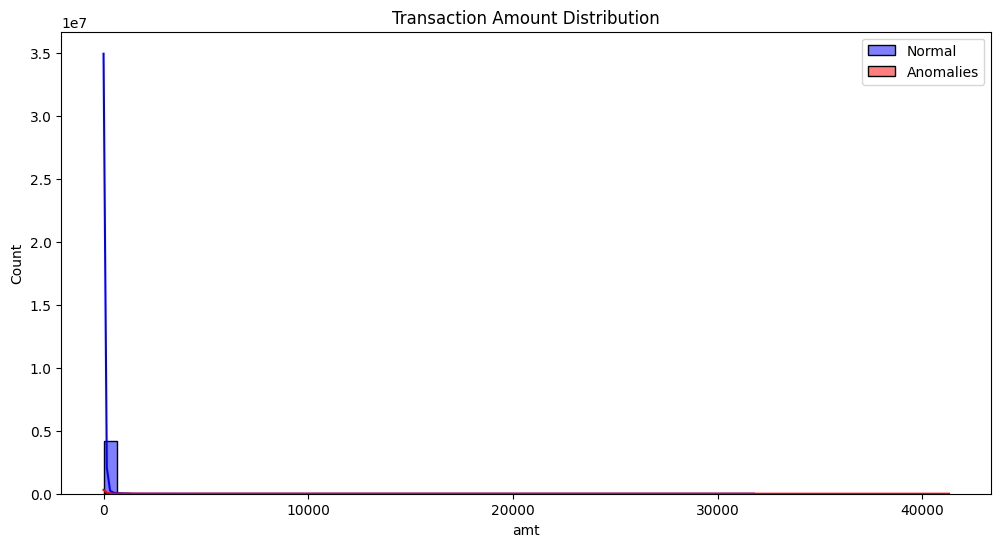

In [ ]:
# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(normal_df['amt'], color='blue', label='Normal', kde=True, bins=50)
sns.histplot(anomalies_df['amt'], color='red', label='Anomalies', kde=True, bins=50)
plt.title('Transaction Amount Distribution')
plt.legend()
plt.show()

<ipython-input-32-5fde6b9cb8ab>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='anomaly', y='amt', palette=['red', 'blue'])


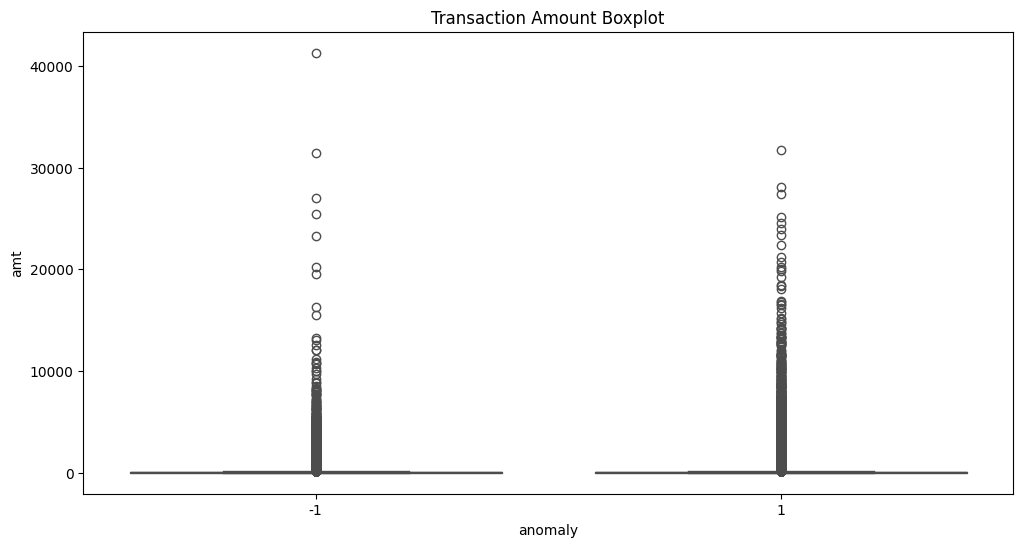

In [ ]:
# Box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_merged, x='anomaly', y='amt', palette=['red', 'blue'])
plt.title('Transaction Amount Boxplot')
plt.show()

*  **High Transaction Amounts:** Both normal and anomalous transactions have high transaction amounts as outliers. However, anomalies have a wider range of high values, suggesting that extremely high transaction amounts are more likely to be flagged as anomalies.

*  **Low Transaction Amounts:** The majority of normal transactions are low in value, and although anomalies also include low transaction amounts, the frequency is much lower.

*  **Outliers:** The presence of extreme outliers in both distributions indicates that high-value transactions are a key factor in identifying anomalies.

**[9.6]** Visualising Geographical Coordinates

In [ ]:
# Scatter Plot for Merchant Coordinates
plt.figure(figsize=(12, 6))
plt.scatter(normal_df['merch_long'], normal_df['merch_lat'], color='blue', alpha=0.5, label='Normal')
plt.scatter(anomalies_df['merch_long'], anomalies_df['merch_lat'], color='red', alpha=0.5, label='Anomalies')
plt.title('Geographical Distribution of Transactions (Merchant)')
plt.xlabel('Merchant Longitude')
plt.ylabel('Merchant Latitude')
plt.legend()
plt.show()


*  **Extreme Latitudes and Longitudes:** There are clusters of anomalies in regions with extreme latitude and longitude values, such as high latitudes around 60° and low latitudes around 20°, and longitudes around -160°. These regions are less densely populated and might be associated with unusual or fraudulent transactions.
*  **Remote Areas:** Some anomalies are isolated in remote areas, far from clusters of normal transactions. These isolated points could indicate transactions occurring in unusual locations for the customer, signaling potential fraud.
*  **Dense Clusters:** Anomalies appear as dense clusters in certain regions, suggesting potential hotspots for suspicious activity.

Investigating these regions further could reveal patterns of fraudulent activities specific to certain geographical areas.

In [ ]:
# Calculate the number of anomalies for each zip code
zip_anomaly_counts = df_merged[df_merged['anomaly'] == -1].groupby(['zip', 'state']).size().reset_index(name='Anomaly_Count')

# Sort by the number of anomalies in descending order
zip_anomaly_counts_sorted = zip_anomaly_counts.sort_values(by='Anomaly_Count', ascending=False)

# Select the top 10 zip codes with the highest number of anomalies
top_10_zip_anomalies = zip_anomaly_counts_sorted.head(10)

# Display the result
print("Top 10 Zip Codes with Anomalies:")
print(top_10_zip_anomalies)

Top 10 Zip Codes with Anomalies:
       zip state  Anomaly_Count
334  96720    HI          15260
337  96746    HI          10550
380  99645    AK           5812
338  96749    HI           5096
379  99575    AK           4721
335  96731    HI           4380
381  99654    AK           3994
339  96766    HI           3278
345  96826    HI           3250
340  96782    HI           2932


**[9.7]** Visualising Hour of Transaction (hour)

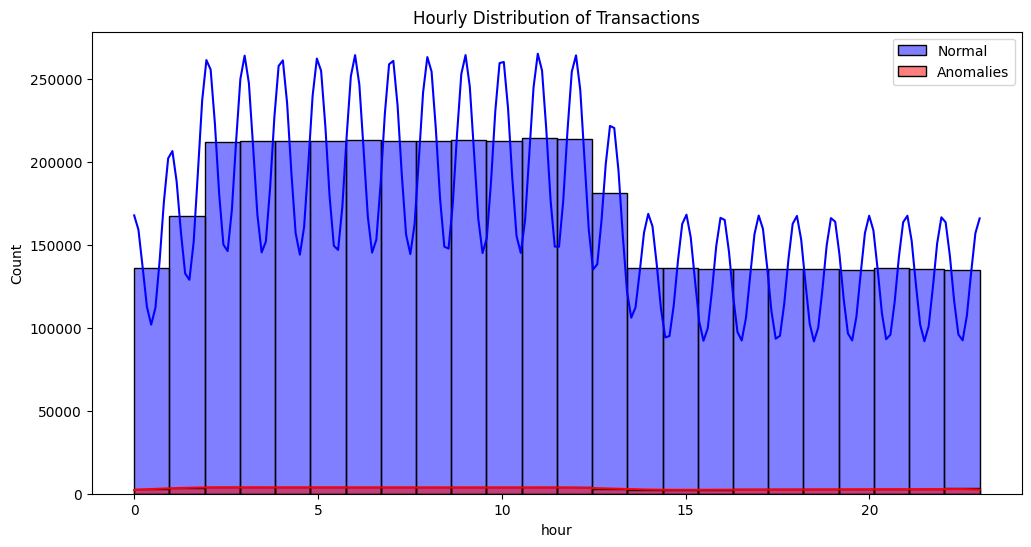

In [ ]:
# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(normal_df['hour'], color='blue', label='Normal', kde=True, bins=24)
sns.histplot(anomalies_df['hour'], color='red', label='Anomalies', kde=True, bins=24)
plt.title('Hourly Distribution of Transactions')
plt.legend()
plt.show()

Anomalous transactions are relatively few compared to normal transactions and are spread throughout the day. They appear consistently across all hours with no significant peaks.

Anomalies are present in all hours of the day, suggesting that unusual transactions can occur at any time, rather than being confined to specific periods.

The majority of normal transactions occur during regular business hours, with a higher concentration from morning to early afternoon. Anomalies, however, do not follow this pattern and are more uniformly distributed across all hours.

The consistent presence of anomalies throughout the day indicates that time of day alone may not be a strong predictor of anomalies.

**[9.8]** Visualising Age at Transaction

<ipython-input-27-69d12237c160>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_df['age_group'] = pd.cut(normal_df['age_at_transaction'], bins=age_bins, labels=age_labels, right=False)
<ipython-input-27-69d12237c160>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies_df['age_group'] = pd.cut(anomalies_df['age_at_transaction'], bins=age_bins, labels=age_labels, right=False)


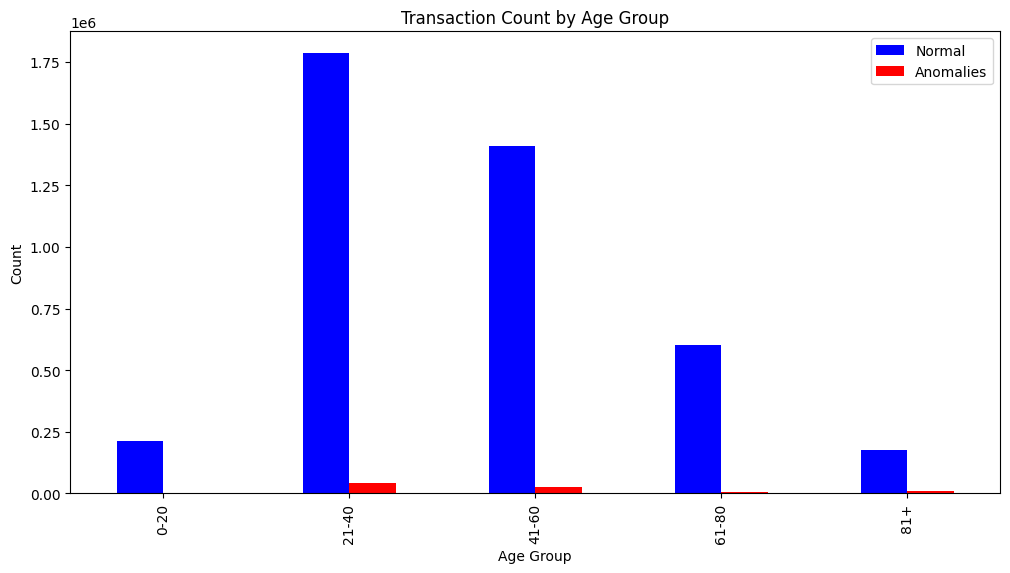

In [ ]:
# Define age groups
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '21-40', '41-60', '61-80', '81+']
normal_df['age_group'] = pd.cut(normal_df['age_at_transaction'], bins=age_bins, labels=age_labels, right=False)
anomalies_df['age_group'] = pd.cut(anomalies_df['age_at_transaction'], bins=age_bins, labels=age_labels, right=False)

# Count of anomalies and normal transactions in each age group
normal_age_group_counts = normal_df['age_group'].value_counts().sort_index()
anomaly_age_group_counts = anomalies_df['age_group'].value_counts().sort_index()

# Create a DataFrame for better plotting
age_group_comparison = pd.DataFrame({
    'Normal': normal_age_group_counts,
    'Anomalies': anomaly_age_group_counts
}).sort_index()

# Plot the counts
age_group_comparison.plot(kind='bar', figsize=(12, 6), color=['blue', 'red'])
plt.title('Transaction Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend()
plt.show()


*  **21-40 and 41-60 Age Groups:** These age groups have the highest counts of anomalous transactions, though the number is much lower compared to normal transactions. There are a few anomalies in the 61-80 and 81+ age groups.

The 21-40 and 41-60 age groups show the highest transaction activity, both for normal and anomalous transactions. This indicates that individuals in these age ranges are the most active in making transactions, which could be due to their economic activity levels.

**[9.9]** Visualising City Population

In [ ]:
# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_merged, x='anomaly', y='city_pop', palette=['red', 'blue'])
plt.title('City Population Boxplot')
plt.show()


<ipython-input-31-8ba85c0e0a5b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='anomaly', y='city_pop', palette=['red', 'blue'])


Transactions in cities with smaller populations are more common, both for normal and anomalous transactions. However, anomalies tend to be slightly more concentrated in smaller cities.

The concentration of anomalies in cities with smaller populations indicates that unusual transactions may be more likely to occur in less populated areas. This could be due to various factors, including less oversight or fewer security measures.

**[9.10]** Visualising Categories

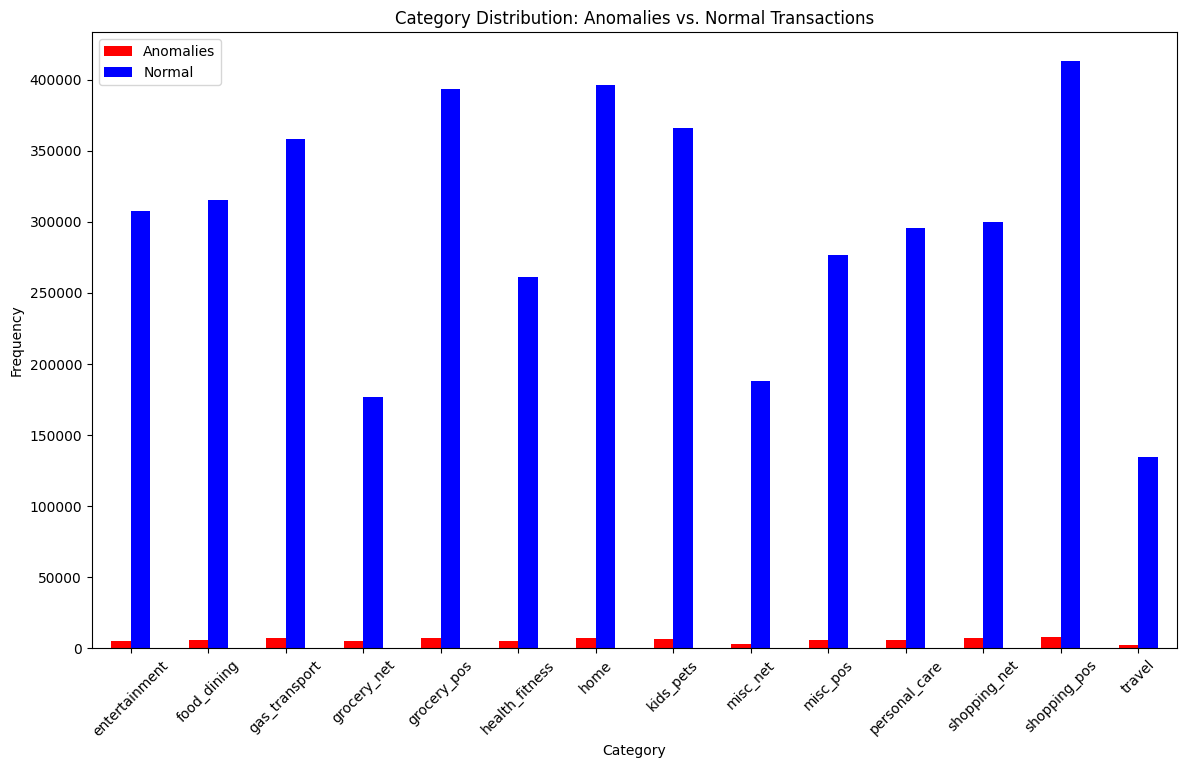

In [ ]:
# Count of each category in anomalies and normal transactions
anomaly_category_counts = anomalies_df['category'].value_counts()
normal_category_counts = normal_df['category'].value_counts()

# Create a DataFrame for better plotting
category_comparison = pd.DataFrame({
    'Anomalies': anomaly_category_counts,
    'Normal': normal_category_counts
}).sort_index()

# Plotting the comparison
category_comparison.plot(kind='bar', figsize=(14, 8), color=['red', 'blue'])
plt.title('Category Distribution: Anomalies vs. Normal Transactions')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.show()



While the number of anomalous transactions is much lower across all categories, the relative distribution among categories appears similar to normal transactions. Anomalies are present in all categories, with the highest counts in categories with the highest normal transaction frequencies.

High-frequency categories such as Shopping POS, Home, and Grocery POS are common spending areas for customers. These categories also see the highest number of anomalies, suggesting that monitoring these areas for unusual activity is crucial.

**Correlation Analysis**

**[9.11]** Correlation Matrix for the Anomalies Dataset

<ipython-input-38-0638cebdd1c3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged_corr = df_merged.corr()


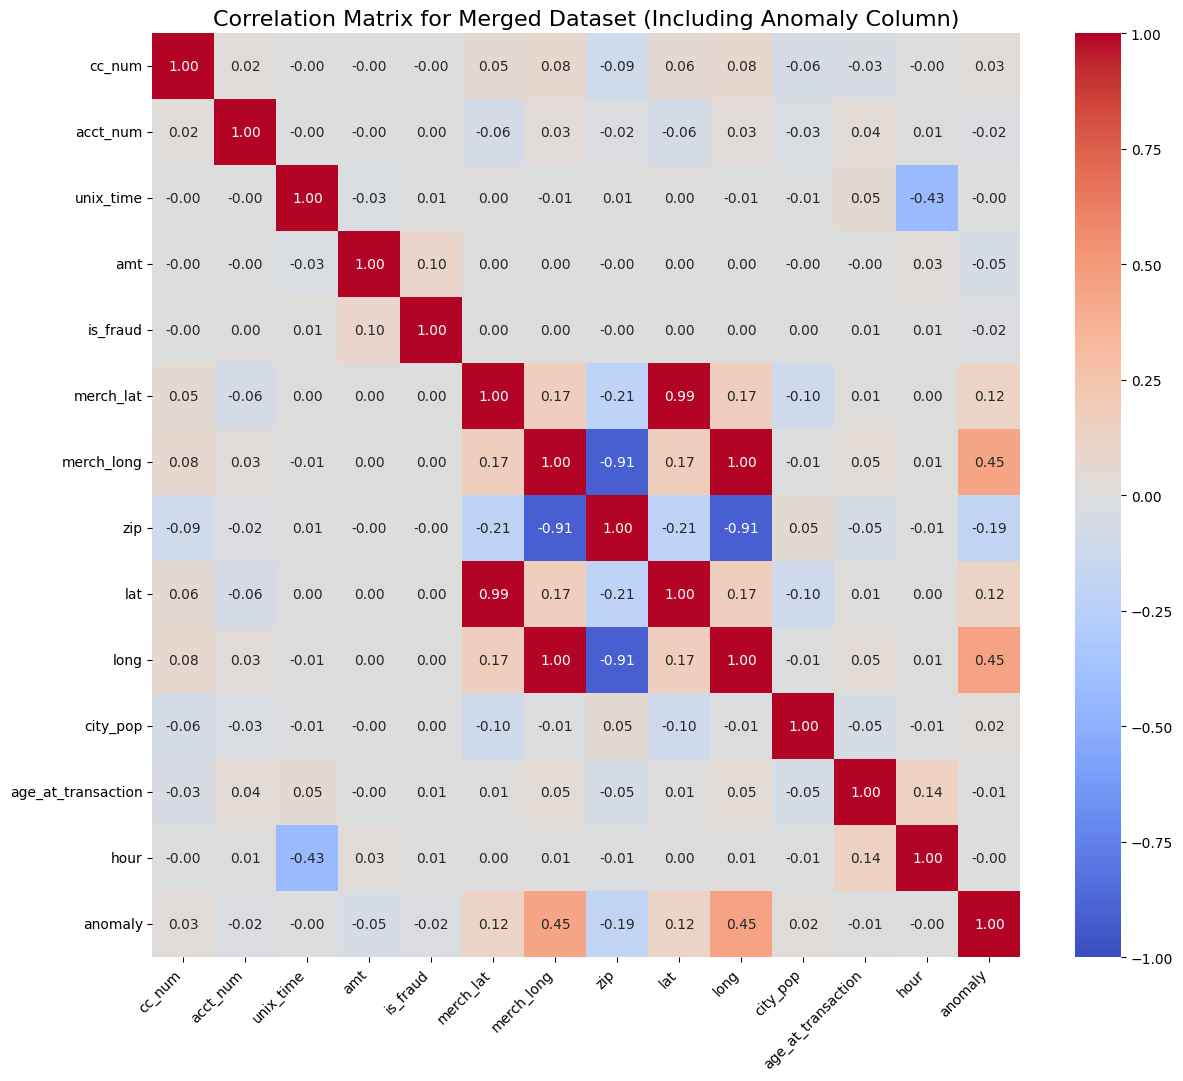

In [ ]:
# Calculate the correlation matrix for the df_merged dataset
merged_corr = df_merged.corr()

# Plot the correlation matrix with improved label alignment
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(merged_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 10})

# Improve label alignment
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.title('Correlation Matrix for Merged Dataset (Including Anomaly Column)', fontsize=16)
plt.show()

*  **merch_long and long:** Both merchant longitude (merch_long) and customer location longitude (long) show a positive correlation of 0.45 with anomaly. This suggests that transactions with certain longitude values are more likely to be flagged as anomalies.

*  **merch_lat and lat:** Both merchant latitude (merch_lat) and customer location latitude (lat) show a weaker positive correlation of 0.12 with anomaly.

*  **zip:** The negative correlation between zip and anomaly suggests that anomalies are more likely to occur in specific zip codes. This could be due to socio-economic factors or regional fraud trends.

The strong correlation between geographical coordinates (latitude and longitude) and anomaly indicates that the location of the transaction plays a significant role in identifying anomalies. This might be due to certain locations being more prone to fraudulent activities.

### 10. Train PCA

**[10.1]** Instantiate a new PCA called `pca` with 2 components only

In [ ]:
pca = PCA(2)

**[10.2]** Fit `pca` on `X_scaled_df`



In [ ]:
pca.fit(X_scaled_df)

PCA(n_components=2)

**[10.3]** Save the explained variance ratio of the principal components into a variable called `pc_variance_ratio`

In [ ]:
pc_variance_ratio = pca.explained_variance_ratio_
pc_variance_ratio

array([0.10678546, 0.07596   ])

**[10.4]** Create a list called `pc_list` that will contain the name of each principal component (PC1, PC2, ...)

In [ ]:
pc_list = [f'PC{i}' for i in list(range(1, len(pc_variance_ratio) + 1))]
pc_list

['PC1', 'PC2']

**[10.5]** Create a dictionary called `pc_loadings` that will have the name of principal component as keys and their corresponding loadings as values

In [ ]:
pc_loadings = dict(zip(pc_list, pca.components_))

**[10.6]** Convert `pc_loadings` to a dataframe called `loadings_df`

In [ ]:
loadings_df = pd.DataFrame(pc_loadings)
loadings_df

PC1       PC2
0  -0.005431 -0.008705
1  -0.499683  0.486618
2  -0.494829 -0.498058
3  -0.500081  0.486130
4  -0.494868 -0.498007
5  -0.014622 -0.073458
6   0.089341 -0.122431
7  -0.045934 -0.073056
8   0.000612  0.009154
9   0.000602  0.013349
10  0.005998 -0.046728
11  0.003612 -0.004389
12 -0.005420 -0.034885
13  0.003471  0.020921
14 -0.000742  0.006752
15 -0.002768  0.014336
16  0.000027  0.003557
17  0.001427 -0.010216
18 -0.005721  0.020857
19  0.003026  0.007824
20 -0.002500  0.002963
21  0.000466  0.004047

**[10.7]** Prepend a column called `feature_names` to `loadings_df` that will contain the name of the original features

In [ ]:
loadings_df.insert(0,'feature_names', X_scaled_df.columns)
loadings_df

feature_names       PC1       PC2
0                       amt -0.005431 -0.008705
1                 merch_lat -0.499683  0.486618
2                merch_long -0.494829 -0.498058
3                       lat -0.500081  0.486130
4                      long -0.494868 -0.498007
5                      hour -0.014622 -0.073458
6                  city_pop  0.089341 -0.122431
7        age_at_transaction -0.045934 -0.073056
8    category_entertainment  0.000612  0.009154
9      category_food_dining  0.000602  0.013349
10   category_gas_transport  0.005998 -0.046728
11     category_grocery_net  0.003612 -0.004389
12     category_grocery_pos -0.005420 -0.034885
13  category_health_fitness  0.003471  0.020921
14            category_home -0.000742  0.006752
15       category_kids_pets -0.002768  0.014336
16        category_misc_net  0.000027  0.003557
17        category_misc_pos  0.001427 -0.010216
18   category_personal_care -0.005721  0.020857
19    category_shopping_net  0.003026  0.007824
20    category_shopping_pos -0.002500  0.002963
21          category_travel  0.000466  0.004047

**[10.8]** Display a horizontal bar chart with the loadings of PC1 against the original features

In [ ]:
alt.Chart(loadings_df).mark_bar().encode(
    x='PC1:Q',
    y="feature_names:N"
)

alt.Chart(...)

*  **merch_long (Merchant Longitude), long (Customer Longitude), merch_lat (Merchant Latitude), and lat (Customer Latitude):**
The high loadings of geographical coordinates suggest that the first principal component is heavily influenced by the location of transactions. This aligns with earlier observations that geographical patterns play a crucial role in distinguishing normal transactions from anomalies.

*  **City Population:** The positive loading of city_pop indicates that transactions in more populous cities have distinct patterns that contribute to PC1. This could be due to the higher transaction volume and diversity in larger cities.

*  **Categories:** The minimal loadings of transaction categories suggest that these features do not significantly contribute to the variance captured by PC1.

**[10.9]** Display a horizontal bar chart with the loadings of PC2 against the original features

In [ ]:
alt.Chart(loadings_df).mark_bar().encode(
    x='PC2:Q',
    y="feature_names:N"
)

alt.Chart(...)

*  Both latitude and longitude coordinates and city population are significant contributors to PC2, similar to PC1.

### 11.   Perform Dimensionality Reduction with PCA

**[11.1]** Apply PCA transformation on `X_scaled_df` using `pca` and save the outputs into a dataframe called `res_df`

In [ ]:
res_df = pd.DataFrame(pca.transform(X_scaled_df))
res_df

0         1
0       -1.500350 -0.783685
1       -1.665877 -0.594772
2       -1.530315 -0.644639
3       -1.557238 -0.743405
4       -1.627251 -0.817251
...           ...       ...
4260899  1.964409  1.104061
4260900  1.937131  0.950659
4260901  2.090275  0.816174
4260902  2.015478  1.000516
4260903  2.048971  0.923712

[4260904 rows x 2 columns]

**[11.2]** Rename the columns of `res_df` to PC1 and PC2. Display its content

In [ ]:
res_df.columns = ['PC1', 'PC2']

**[11.3]** Copy the content of columns `anomaly` from `df_merged` into a new column called `anomaly` in `res_df`

In [ ]:
res_df['anomaly'] = df_merged['anomaly']

**[11.4]** Display a scatter plot showing the observations from `res_df` against PC1 and PC2

In [ ]:
sampled_res_df = res_df.sample(n=50000, random_state=42)

# Disable max rows for Altair to allow plotting of the entire sampled dataset
alt.data_transformers.disable_max_rows()

# Create the Altair chart with the sampled data
chart = alt.Chart(sampled_res_df).mark_circle(opacity=0.3).encode(
    x='PC1',
    y='PC2',
    color='anomaly:N'
).properties(
    title='PCA Scatter Plot of Sampled Data'
)

chart.display()

alt.Chart(...)

The scatter plot shows the distribution of transactions based on the first two principal components (PC1 and PC2) derived from the PCA analysis.

There are distinct clusters of anomalies (blue points) in the plot, indicating regions in the principal component space where transactions exhibit unusual patterns.

*  At the top of the plot, around PC1 values between -3 and 2 and PC2 values between 5 and 9.

*  On the right side of the plot, around PC1 values between 5 and 7 and PC2 values between -2 and 2.

*  The normal transactions (orange points) form a dense cluster in the central part of the plot.

The distinct clustering of anomalies indicates that PCA is effective in reducing the dimensionality of the dataset while retaining the features that differentiate normal and anomalous transactions.

The separation between anomalies and normal transactions suggests that the IsolationForest model used for anomaly detection is performing well, as it identifies outliers that stand apart from the majority of the data.

Implement real-time monitoring of transactions using the identified principal components. By tracking the values of PC1 and PC2, it is possible to quickly detect and respond to unusual patterns in transaction data.